In [2]:
ds <- read.csv('train.csv')
head(ds)

,ID,gender,age,height,weight,cholesterol,systolic_blood_pressure,diastolic_blood_pressure,glucose,bone_density,activity,smoke_status,medical_history,family_medical_history,sleep_pattern,edu_level,mean_working,stress_score
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,TRAIN_0000,F,72,161.49,58.47,279.84,165,100,143.35,0.87,moderate,ex-smoker,high blood pressure,diabetes,sleep difficulty,bachelors degree,NA,0.63
2,TRAIN_0001,M,88,179.87,77.60,257.37,178,111,146.94,0.07,moderate,ex-smoker,,diabetes,normal,graduate degree,NA,0.83
3,TRAIN_0002,M,47,182.47,89.93,226.66,134,95,142.61,1.18,light,ex-smoker,,,normal,high school diploma,9,0.70
4,TRAIN_0003,M,69,185.78,68.63,206.74,158,92,137.26,0.48,intense,ex-smoker,high blood pressure,,oversleeping,graduate degree,NA,0.17
5,TRAIN_0004,F,81,164.63,71.53,255.92,171,116,129.37,0.34,moderate,ex-smoker,diabetes,diabetes,sleep difficulty,bachelors degree,NA,0.36
6,TRAIN_0005,M,18,173.55,59.00,217.46,121,73,103.79,1.61,moderate,non-smoker,,,normal,high school diploma,NA,0.83


In [3]:
install.packages("tidyverse")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [21]:
library(tidyverse)

# 1) 데이터
df <- readr::read_csv("train.csv")

# 2) 사용자 지정: 순서형(내림차순 의미) / 명목형
ord_levels <- list(
  activity     = c("intense", "moderate", "light"),
  smoke_status = c("smoker", "ex-smoker", "non-smoker"),
  edu_level    = c("graduate degree", "bachelors degree", "high school degree",
                   "middle school degree", "no formal education")
)
nominal_vars <- c("medical_history", "family_medical_history", "sleep_pattern")

# 3) 헬퍼 함수
to_ord <- function(x, levels_desc) {
  x2 <- tolower(trimws(as.character(x)))
  lv <- tolower(levels_desc)
  # 큰 값이 큰 정수: factor 레벨을 '작은→큰' 순서로 두면 as.integer가 1..K로 나옵니다.
  # levels_desc는 '큰→작은'이므로 rev(lv)로 '작은→큰'을 만들어 사용
  as.integer(factor(x2, levels = rev(lv), ordered = TRUE))
}

to_nom <- function(x) {
  f <- factor(as.character(x))
  k <- nlevels(f)
  codes <- seq(from = 1, by = -1, length.out = k)  # 1, 0, -1, -2, ...
  codes[as.integer(f)]
}

# 4) 변환 (원본 컬럼을 교체)
df_converted <- df |>
  mutate(
    across(any_of(names(ord_levels)),
           ~ to_ord(.x, ord_levels[[cur_column()]]))
  ) |>
  mutate(
    across(any_of(nominal_vars),
           ~ to_nom(.x))
  )

# 5) 확인: 바뀐 컬럼만 보기
head(df_converted)

# 6) 저장
readr::write_csv(df_converted, "df_converted.csv")  # CSV 저장 (UTF-8)
saveRDS(df_converted, "df_converted.rds")           # 타입 보존용 RDS 저장

Rows: 3000 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): ID, gender, activity, smoke_status, medical_history, family_medica...
dbl (10): age, height, weight, cholesterol, systolic_blood_pressure, diastol...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID,gender,age,height,weight,cholesterol,systolic_blood_pressure,diastolic_blood_pressure,glucose,bone_density,activity,smoke_status,medical_history,family_medical_history,sleep_pattern,edu_level,mean_working,stress_score
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
TRAIN_0000,F,72,161.49,58.47,279.84,165,100,143.35,0.87,2,2,-1,1,-1,4,NA,0.63
TRAIN_0001,M,88,179.87,77.60,257.37,178,111,146.94,0.07,2,2,NA,1,1,5,NA,0.83
TRAIN_0002,M,47,182.47,89.93,226.66,134,95,142.61,1.18,1,2,NA,NA,1,NA,9,0.70
TRAIN_0003,M,69,185.78,68.63,206.74,158,92,137.26,0.48,3,2,-1,NA,0,5,NA,0.17
TRAIN_0004,F,81,164.63,71.53,255.92,171,116,129.37,0.34,2,2,1,1,-1,4,NA,0.36
TRAIN_0005,M,18,173.55,59.00,217.46,121,73,103.79,1.61,2,1,NA,NA,1,NA,NA,0.83


In [23]:
library(tidyverse)

df_converted <- read_csv("df_converted.csv")

# 명목형 변환 함수
to_nom <- function(x) {
  f <- factor(as.character(x))
  k <- nlevels(f)
  codes <- seq(from = 1, by = -1, length.out = k)  # 1, 0, -1, ...
  codes[as.integer(f)]
}

# gender를 명목형 코드로 변환
df_converted <- df_converted %>%
  mutate(
    gender = to_nom(gender)
  )

# 결측치 처리 + 플래그 생성
df_filled <- df_converted %>%
  mutate(
    # 병력/가족력: NA → 0
    medical_history = replace_na(medical_history, 0),
    family_medical_history = replace_na(family_medical_history, 0),

    # smoke_status: NA → -1 (정보 없음)
    smoke_status = replace_na(smoke_status, -1),

    # edu_level: NA → 0 ("Unknown" 의미)
    edu_level = replace_na(edu_level, 0),

    # mean_working: NA → 중앙값
    mean_working = replace_na(mean_working, median(mean_working, na.rm = TRUE))
  ) %>%
  mutate(
    miss_gender  = is.na(df_converted$gender),
    miss_smoke   = is.na(df_converted$smoke_status),
    miss_med     = is.na(df_converted$medical_history),
    miss_fam_med = is.na(df_converted$family_medical_history),
    miss_edu     = is.na(df_converted$edu_level),
    miss_work    = is.na(df_converted$mean_working)
  )

# 저장
write_csv(df_filled, "df_filled.csv")

Rows: 3000 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ID, gender
dbl (16): age, height, weight, cholesterol, systolic_blood_pressure, diastol...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

corrplot 0.95 loaded

Rows: 3000 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ID
dbl (17): gender, age, height, weight, cholesterol, systolic_blood_pressure,...
lgl  (6): miss_gender, miss_smoke, miss_med, miss_fam_med, miss_edu, miss_work

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows x Cols: 3000 x 24 

컬럼 타입 요약:
# A tibble: 1 × 24
  ID        gender  age     height  weight  cholesterol systolic_blood_pressure
  <chr>     <chr>   <chr>   <chr>   <chr>   <chr>       <chr>                  
1 character numeric numeric numeric numeric numeric     numeric                
# ℹ 17 more variables: diastolic_blood_pressure <chr>, glucose <chr>,
#   bone_density <chr>, activity <chr>, smoke_status <chr>,
#   medical_history <chr>, family_medical_history <chr>, sleep_pattern <chr>,
#   edu_level <chr>, mean_working <chr>, stress_score <chr>, miss_gender <chr>,
#   miss_smoke <chr>, miss_med <chr>, miss_fam_med <chr>, miss_edu <chr>,
#   miss_work <chr>

NA 개수:
                      ID                   gender                      age 
                       0                        0                        0 
                  height                   weight              cholesterol 
                       0                        0                        0 
 systolic_bl

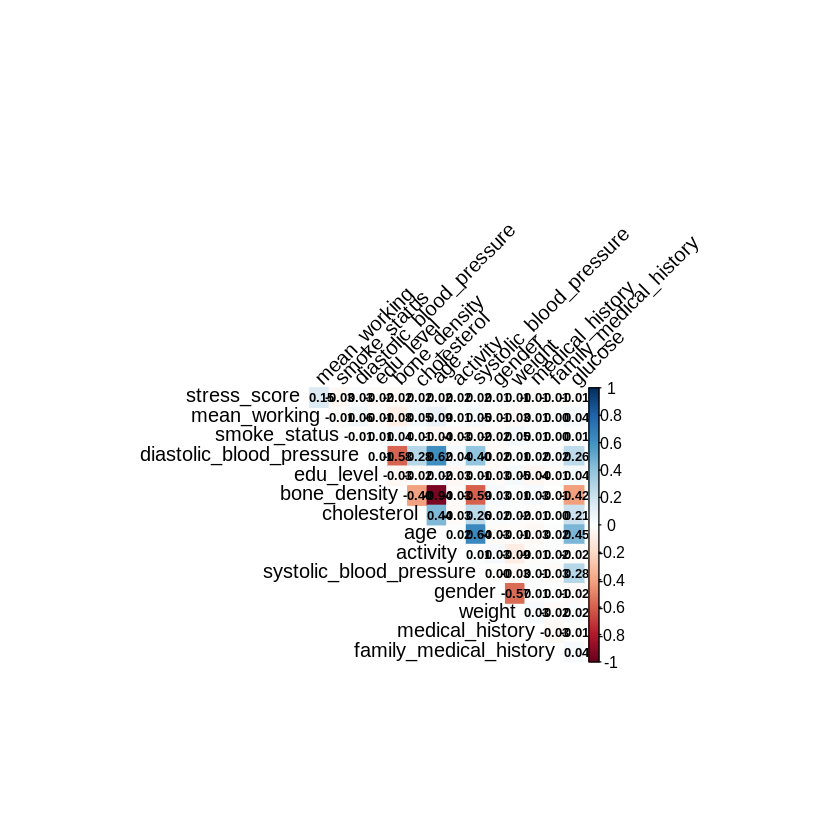

In [25]:
# =========================
# 0) 패키지
# =========================
suppressPackageStartupMessages({
  library(tidyverse)
})

# corrplot은 선택 (히트맵 그릴 때 사용)
if (!requireNamespace("corrplot", quietly = TRUE)) {
  install.packages("corrplot")
}
library(corrplot)

# =========================
# 1) 데이터 로드
# =========================
df <- readr::read_csv("df_filled.csv", guess_max = 100000)

# =========================
# 2) 메타 정보
# =========================
cat("Rows x Cols:", paste(dim(df), collapse = " x "), "\n\n")

cat("컬럼 타입 요약:\n")
print(df %>% summarise(across(everything(), ~ class(.x)[1])))

cat("\nNA 개수:\n")
print(colSums(is.na(df)))

cat("\n수치형 변수 요약(일부):\n")
print(df %>% select(where(is.numeric)) %>% summary())

# =========================
# 3) 상관행렬(피어슨)
# =========================
num_df <- df %>% select(where(is.numeric))

# ID 열이 숫자인 식별자이면 제거
if ("ID" %in% names(num_df)) {
  # 단순히 존재하면 제거 (원하면 고유성/단조 증가 여부 체크해도 됨)
  num_df <- num_df %>% select(-ID)
}

# 상관행렬
corr_mat <- cor(num_df, use = "pairwise.complete.obs", method = "pearson")

# 타깃과의 상관계수 정렬
if (!"stress_score" %in% colnames(corr_mat)) {
  stop("`stress_score` 컬럼이 수치형으로 존재하지 않습니다.")
}
corr_with_target <- sort(corr_mat[, "stress_score"], decreasing = TRUE)

cat("\n--- stress_score와의 상관계수 (상위→하위) ---\n")
print(round(corr_with_target, 4))

# =========================
# 4) 히트맵 시각화 (선택)
# =========================
# 변수 많으면 복잡하니, 상위 15개(절댓값 기준) 변수만 뽑아서 그릴 수도
topk <- 15
ord <- order(abs(corr_mat[,"stress_score"]), decreasing = TRUE)
vars_topk <- colnames(corr_mat)[ord][1:min(topk, ncol(corr_mat))]
corr_topk <- corr_mat[vars_topk, vars_topk]

# 히트맵
corrplot::corrplot(corr_topk, method = "color", type = "upper",
                   tl.col = "black", tl.srt = 45, number.cex = .65,
                   addCoef.col = "black", diag = FALSE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



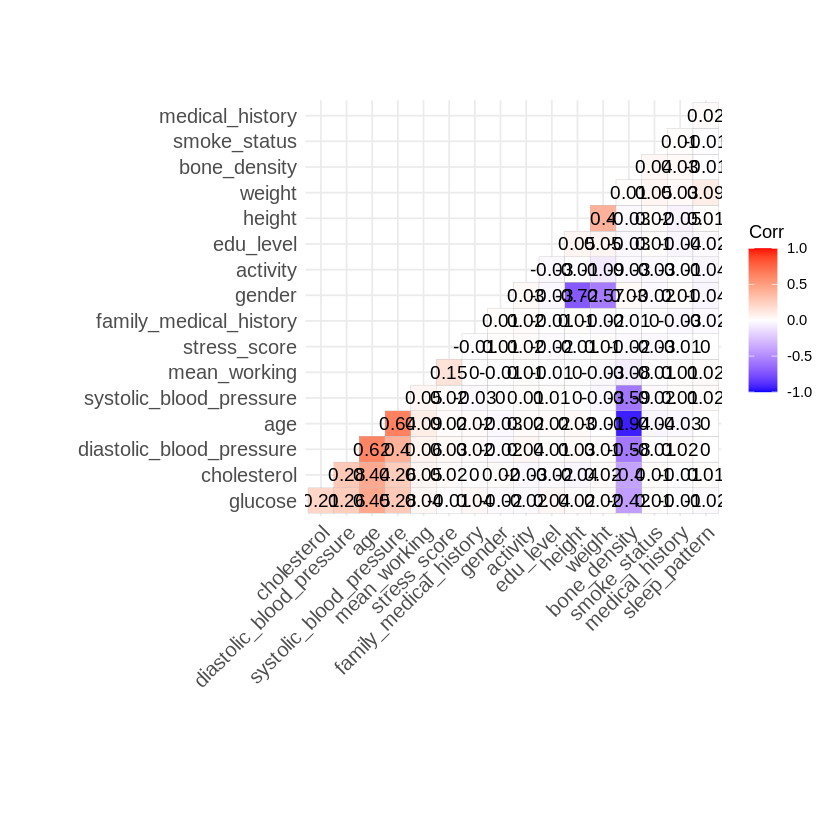

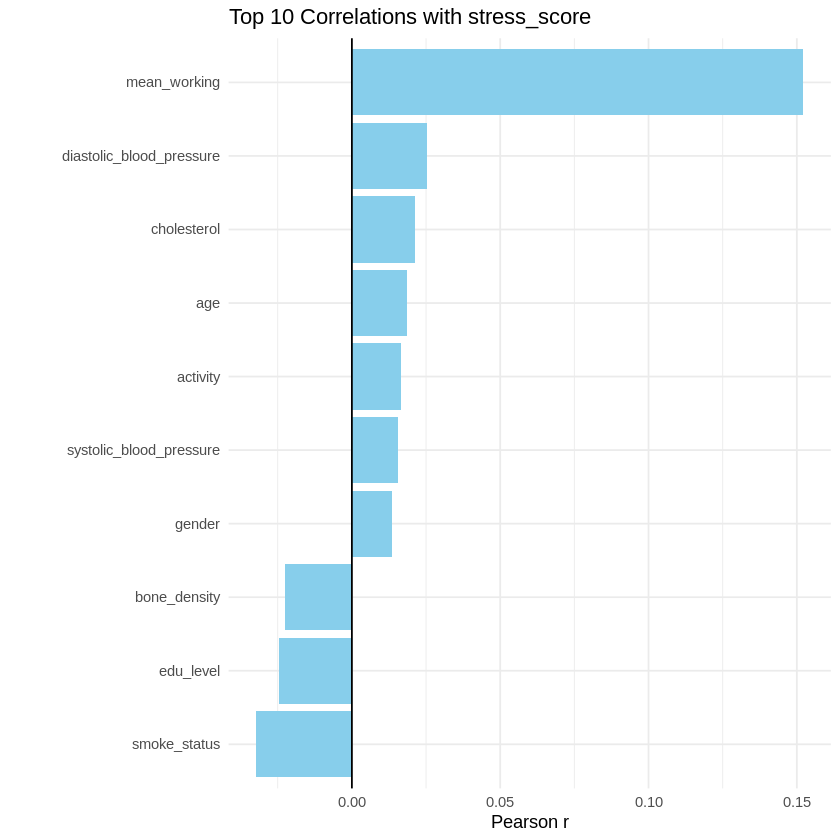

In [28]:
install.packages("ggcorrplot")
library(ggcorrplot)

num_df <- df %>% select(where(is.numeric)) %>% select(-any_of("ID"))
corr <- cor(num_df, use = "pairwise.complete.obs")

# 전체 히트맵
ggcorrplot(corr, hc.order = TRUE, type = "lower", lab = TRUE)

# stress_score와 절댓값 기준 상위 10개 변수
target <- "stress_score"
corr_with_target <- sort(corr[, target], decreasing = TRUE)
top_vars <- names(sort(abs(corr_with_target), decreasing = TRUE))[2:11]

ggplot(
  tibble(var = top_vars, r = corr_with_target[top_vars]),
  aes(x = reorder(var, r), y = r)
) +
  geom_col(fill = "skyblue") +
  geom_hline(yintercept = 0) +
  coord_flip() +
  labs(title = "Top 10 Correlations with stress_score", x = NULL, y = "Pearson r") +
  theme_minimal()

ERROR: [1m[33mError[39m in `pivot_longer()`:[22m
[33m![39m Can't combine `ID` <character> and `miss_gender` <logical>.


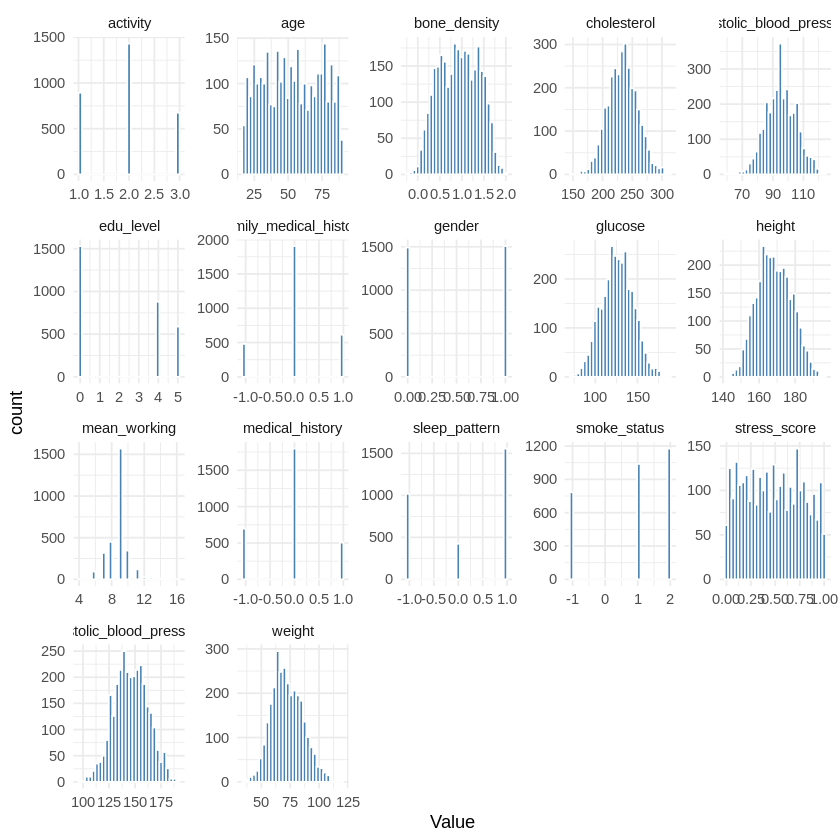

In [29]:
# 수치형 변수 분포 (히스토그램)
num_df %>%
  pivot_longer(cols = everything(), names_to = "Variable", values_to = "Value") %>%
  ggplot(aes(x = Value)) +
  geom_histogram(fill = "steelblue", color = "white", bins = 30) +
  facet_wrap(~Variable, scales = "free") +
  theme_minimal()

# 범주형 변수 분포 (막대그래프)
df %>%
  select(where(~!is.numeric(.))) %>%
  pivot_longer(cols = everything(), names_to = "Variable", values_to = "Value") %>%
  ggplot(aes(x = Value)) +
  geom_bar(fill = "orange") +
  facet_wrap(~Variable, scales = "free") +
  theme_minimal()

`geom_smooth()` using formula = 'y ~ x'


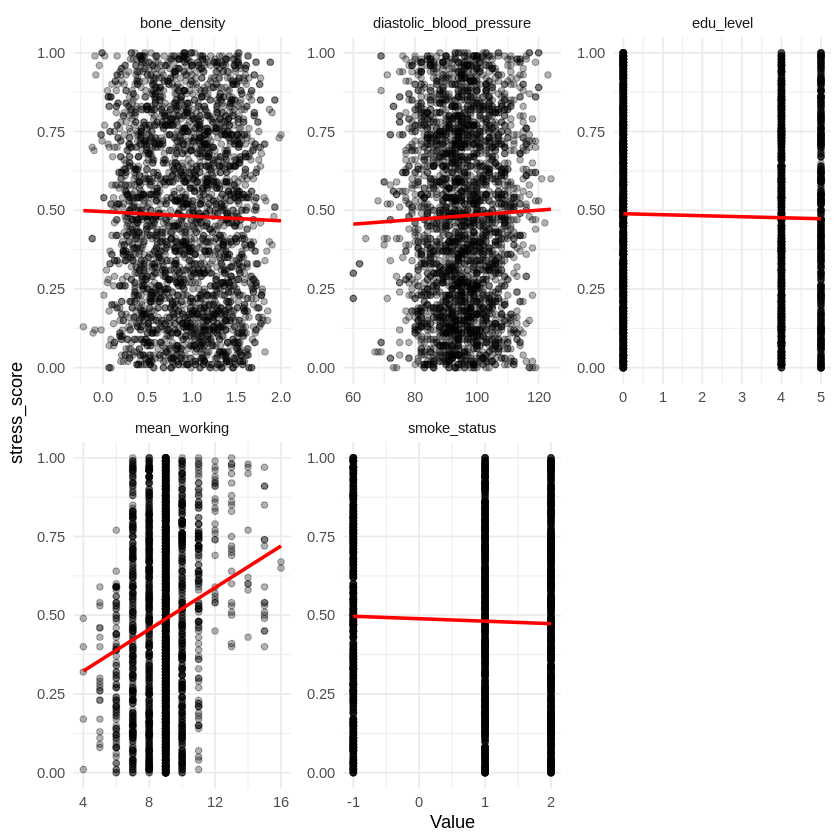

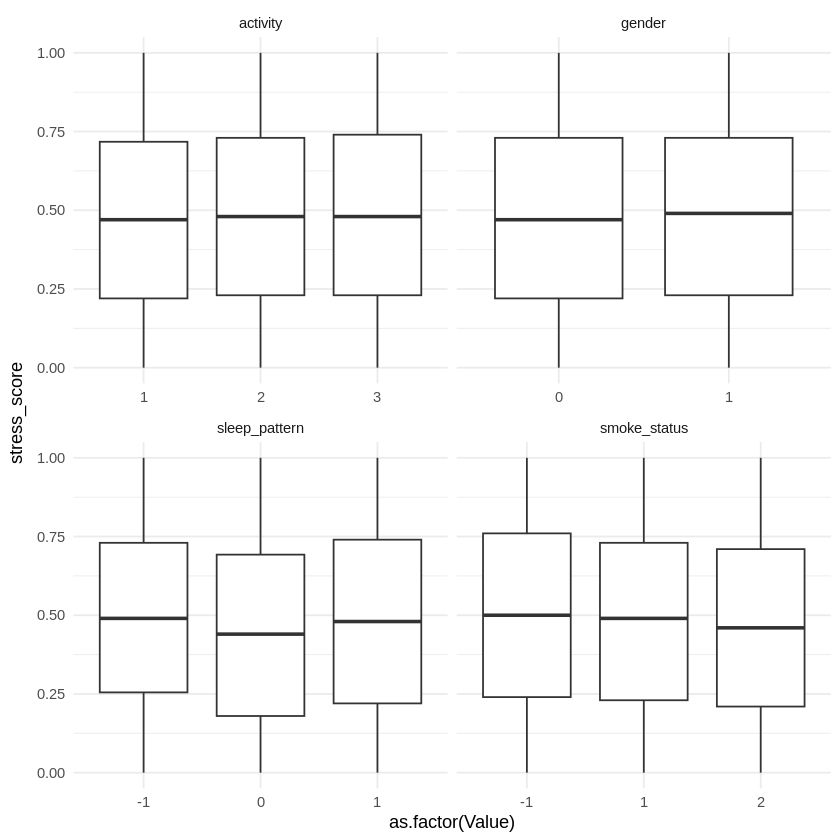

In [30]:
# 연속형 변수 vs stress_score (산점도 + 회귀선)
top_corr_vars <- names(sort(abs(corr_with_target), decreasing = TRUE))[2:6]
df %>%
  pivot_longer(cols = all_of(top_corr_vars), names_to = "Variable", values_to = "Value") %>%
  ggplot(aes(x = Value, y = stress_score)) +
  geom_point(alpha = 0.3) +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  facet_wrap(~Variable, scales = "free") +
  theme_minimal()

# 범주형 변수 vs stress_score (박스플롯)
cat_vars <- c("gender", "smoke_status", "activity", "sleep_pattern")
df %>%
  pivot_longer(cols = all_of(cat_vars), names_to = "Variable", values_to = "Value") %>%
  ggplot(aes(x = as.factor(Value), y = stress_score)) +
  geom_boxplot() +
  facet_wrap(~Variable, scales = "free_x") +
  theme_minimal()